# TASK:

### Deadline: 17 martie ora 23:59.
### Formular pentru trimiterea temei: https://forms.gle/isPikzbiBdNm7AhA6

Vom folosi urmatorul dataset: https://www.kaggle.com/rmisra/news-category-dataset (headline-uri de stiri etichetate conform unei liste de categorii).

1. (optional) Intrucat setul de date contine multe categorii, puteti pastra exemplele din 4-5 clase (selectate de catre voi) si sa rezolvati problema de clasificare doar pentru aceste exemple
2. Incercati mai multe metode de preprocesare si tokenizare a textelor pentru a obtine reprezentari de tip Bag-of-Words (stergeti/nu stergeti stop words, lematizati sau aplicati stemming, pastrati sau eliminati punctuatia, normalizati folosind standardizare, L1, L2 sau Tf-Idf). Implementati **3** astfel de combinatii.
3. Impartiti setul de date in 80% train, 20% test, iar pentru fiecare metoda de preprocesare antrenati un model ales de voi (diferit de Decision Tree) pe datele de train
4. Evaluati modelul pe datele de test, determinand acuratete, precizie, recall, f1, si stabiliti care metoda de procesare a textelor a adus rezultate mai bune.
5. Determinati pentru acest caz care au fost top 10 cele mai importante feature-uri (cuvinte).
6. Folosind aceasta metoda de procesare a textelor, antrenati alte doua modele diferite la alegere si comparati performanta cu modelul original.
7. Pentru cel mai bun model afisati metricile la nivel de clasa (classification report) si matricea de confuzie.

In [184]:
# 1.
import json
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from num2words import num2words
import re
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

nltk.download('wordnet')
nltk.download('omw-1.4')
MAX_FEATURES = 100
CATEGORIES_NUMBER = 5
INITIAL_CATEGORY = 3

all_data = []
frequency_category = defaultdict(lambda : 0)
with open("News_Category_Dataset_v2.json", 'r') as fin:
    lines = fin.readlines()
    for line in lines:
        data_in = json.loads(line)
        all_data.append(data_in)
        frequency_category[data_in['category']] += 1

accepted_categories = list(k for k, v in sorted(frequency_category.items(), key=lambda item: item[1], reverse=True)[INITIAL_CATEGORY:INITIAL_CATEGORY + CATEGORIES_NUMBER])
data = []
labels = []
for din in all_data:
    if din['category'] in accepted_categories:
        data.append(din['headline'])
        labels.append(din['category'])

print(data[:10])
print(labels[:10])


[nltk_data] Downloading package wordnet to /home/alhiris/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/alhiris/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


["'Queer Eye' Star Bobby Berk Gave Me A Desk Makeover -- And It Was Incredible", "Older Gay Men Try Out 'New Gay' Slang In This Hilarious Video", "How 'RuPaul’s Drag Race' Is Teaching Straight People About Queer Culture", "14 Ways To Make Family Road Trips Easier, From Parents Who've Been There", "Tig Notaro Tells Ellen DeGeneres About Her Sons' Passion For Trash", 'Stormy Daniels Thanks ‘Wonderful Gay Dads’ As West Hollywood Hands Her Keys To City', 'Can You Believe? Queer Eye Season 2 Drops Next Month', 'Gay Man Denied Marriage License By Kim Davis Loses Bid To Unseat Her', 'More Americans Than Ever Support Same-Sex Marriage', '14 Trips To Take From New York City On A Long Weekend']
['QUEER VOICES', 'QUEER VOICES', 'QUEER VOICES', 'TRAVEL', 'QUEER VOICES', 'QUEER VOICES', 'QUEER VOICES', 'QUEER VOICES', 'QUEER VOICES', 'TRAVEL']


In [185]:
# not using this anymore
# ! python -m spacy download en_core_web_md


In [186]:
# Realised we can just use CountVectorizer preprocessor & tokenizer but a lil bit less efficient
# data_lower = [headline.lower() for headline in data]
# data_numbers = [re.sub(r"((\d+\.)?\d+)", lambda x: num2words(x.group(0), lang="english") , headline) for headline in data_lower]
# data_punctuation = [headline.translate(str.maketrans('', '', string.punctuation)) for headline in data_numbers]
# data_punctuation = [re.sub(r'\s+', ' ', headline) for headline in data_punctuation]
# nlp = spacy.load("en_core_web_md")
# tokenizer = nlp.tokenizer
# data_tokenized = []
# for doc in tokenizer.pipe(data_punctuation, batch_size=1000):
#     data_tokenized.append([token.text for token in doc])
# stop_words = nlp.defaults.stop_words
# data_stopwords = [[word for word in headline if word not in stop_words] for headline in data_tokenized]


In [187]:
# 2.
def base_data_preprocessing(text):
    text_lower = text.lower()
    text_numbers = re.sub(r"((\d+\.)?\d+)", lambda x: num2words(x.group(0), lang="english") , text_lower)
    text_punctuation = text_numbers.translate(str.maketrans('', '', string.punctuation))
    text_punctuation = re.sub(r'\s+', ' ', text_punctuation) # removing extra spaces just in case
    return text_punctuation

def base_tokenizer(text):
    lemmatizer = WordNetLemmatizer()
    text_tokens = text.split(" ")
    text_lemmatized = [lemmatizer.lemmatize(word) for word in text_tokens]
    return text_lemmatized

def stopwords_tokenizer(text):
    lemmatizer = WordNetLemmatizer()
    text_tokens = text.split(" ")
    stop_words = set(stopwords.words('english'))
    text_lemmatized_stopwords = [lemmatizer.lemmatize(word) for word in text_tokens if word not in stop_words]
    return text_lemmatized_stopwords

# not removing stopwords
count_vectorizer = CountVectorizer(
    tokenizer=base_tokenizer,
    token_pattern=None,
    max_features=MAX_FEATURES,
    binary=False
)

# considering stopwords
count_vectorizer_stopwords = CountVectorizer(
    tokenizer=stopwords_tokenizer,
    token_pattern=None,
    max_features=MAX_FEATURES,
    binary=False
)

# considering stopwords and bigrams
# count_vectorizer_stopwords_bigrams = CountVectorizer(
#     tokenizer=stopwords_tokenizer,
#     token_pattern=None,
#     max_features=50,
#     ngram_range=(2, 2)
# )

data_preprocessed = [base_data_preprocessing(headline) for headline in data]

count_vectorizer.fit(data_preprocessed)
count_vectorizer_stopwords.fit(data_preprocessed)
# count_vectorizer_stopwords_bigrams.fit(data_preprocessed)

print(sorted(list(count_vectorizer.vocabulary_.keys())))
print(sorted(list(count_vectorizer_stopwords.vocabulary_.keys())))
# print(sorted(list(count_vectorizer_stopwords_bigrams.vocabulary_.keys())))

data_features = count_vectorizer.transform(data_preprocessed)
data_features_stopwords = count_vectorizer_stopwords.transform(data_preprocessed)
# data_features_stopwords_bigrams = count_vectorizer_stopwords_bigrams.transform(data_preprocessed)

print(data_features.shape)
print(type(data_features))
print(data_features.toarray()[:5])  # convertim la numpy array


['a', 'about', 'after', 'all', 'an', 'and', 'are', 'at', 'baby', 'be', 'beauty', 'best', 'by', 'can', 'child', 'day', 'do', 'dress', 'family', 'fashion', 'first', 'five', 'for', 'from', 'gay', 'get', 'have', 'health', 'her', 'here', 'hotel', 'how', 'i', 'in', 'is', 'it', 'kid', 'know', 'life', 'like', 'look', 'love', 'make', 'me', 'mom', 'more', 'most', 'my', 'need', 'new', 'not', 'of', 'on', 'one', 'or', 'our', 'out', 'parent', 'people', 'photo', 'say', 'seven', 'should', 'show', 'six', 'star', 'style', 'ten', 'that', 'the', 'their', 'thing', 'thirteen', 'this', 'thousand', 'three', 'time', 'tip', 'to', 'top', 'travel', 'twelve', 'two', 'u', 'up', 'video', 'way', 'we', 'week', 'what', 'when', 'who', 'why', 'will', 'with', 'woman', 'world', 'year', 'you', 'your']
['america', 'american', 'baby', 'back', 'beauty', 'best', 'child', 'city', 'could', 'dad', 'daughter', 'day', 'dont', 'dress', 'eight', 'fall', 'family', 'fashion', 'find', 'first', 'five', 'four', 'fourteen', 'gay', 'get', 'g

In [188]:
# Preparing data for training with multiple methods of preprocessing

# 3 splitting the data
x_train, x_test, y_train, y_test = train_test_split(data_features.toarray(), labels, test_size=0.2, random_state=42)
x_stopwords_train, x_stopwords_test, y_stopwords_train, y_stopwords_test = train_test_split(data_features_stopwords.toarray(), labels, test_size=0.2, random_state=42)

x_tfidf_train, x_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(data_preprocessed, labels, test_size=0.2, random_state=42)
tfidf_vectorizer = TfidfVectorizer(
    tokenizer=stopwords_tokenizer,
    token_pattern=None,
    max_features=MAX_FEATURES,
)

scaler_standard = preprocessing.StandardScaler()
scaler_l2 = preprocessing.Normalizer(norm='l2') # no reason to fit this one

scaler_standard.fit(x_stopwords_train)
tfidf_vectorizer.fit(x_tfidf_train)

models_data = {
    'data_features_l2': {
        'vectorizer': count_vectorizer,
        'x_train': scaler_l2.transform(x_train),
        'y_train': y_train,
        'x_test': scaler_l2.transform(x_test),
        'y_test': y_test
    },
    'data_features_stopwords_l2': {
        'vectorizer': count_vectorizer_stopwords,
        'x_train': scaler_l2.transform(x_stopwords_train),
        'y_train': y_stopwords_train,
        'x_test': scaler_l2.transform(x_stopwords_test),
        'y_test': y_stopwords_test
    },
    'data_features_stopwords_standard': {
        'vectorizer': count_vectorizer_stopwords,
        'x_train': scaler_standard.transform(x_stopwords_train),
        'y_train': y_stopwords_train,
        'x_test': scaler_standard.transform(x_stopwords_test),
        'y_test': y_stopwords_test
    },
    'data_features_stopwords_tfidf': {
        'vectorizer': tfidf_vectorizer,
        'x_train': tfidf_vectorizer.transform(x_tfidf_train).toarray(),
        'y_train': y_tfidf_train,
        'x_test': tfidf_vectorizer.transform(x_tfidf_test).toarray(),
        'y_test': y_tfidf_test
    },
}

In [189]:
# 3 (split was done above)
# print(models_data['data_features_stopwords_tfidf']['x_train'])
for key, model_data in models_data.items():
    model = RandomForestClassifier(
        n_estimators=200,
        min_samples_split=10,
        n_jobs=-1,
        verbose=True
    )
    print(f'Training the {key} model')
    model.fit(model_data['x_train'], model_data['y_train'])
    model_data['model'] = model


Training the data_features_l2 model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


Training the data_features_stopwords_l2 model


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


Training the data_features_stopwords_standard model


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


Training the data_features_stopwords_tfidf model


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    7.9s finished


In [190]:
# 4
best_model_data = None
for key, model_data in models_data.items():
    y_test_prediction = model_data['model'].predict(model_data['x_test'])
    y_true = model_data['y_test']
    accuracy = metrics.accuracy_score(y_true, y_test_prediction)
    precision = metrics.precision_score(y_true, y_test_prediction, average='macro')
    recall = metrics.recall_score(y_true, y_test_prediction, average='macro')
    f1 = metrics.f1_score(y_true, y_test_prediction, average='macro')
    model_data['accuracy'] = accuracy
    model_data['precision'] = precision
    model_data['recall'] = recall
    model_data['f1'] = f1
    print(f'Metric for model {key}:')
    print(f'Accuracy:   {accuracy}')
    print(f'Precision:  {precision}')
    print(f'Recall:     {recall}')
    print(f'F1:         {f1}')
    if best_model_data is None:
        best_model_data = model_data
    elif best_model_data['accuracy'] < accuracy:
        best_model_data = model_data
    # print(metrics.classification_report(y_true, y_test_prediction, digits=5))
    # print(y_test_prediction[:3])
    # print(model_data['y_test'][:3], end='\n\n')

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.1s finished


Metric for model data_features_l2:
Accuracy:   0.565554881746513
Precision:  0.563018941876166
Recall:     0.5509676086946305
F1:         0.5544405106027065


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.1s finished


Metric for model data_features_stopwords_l2:
Accuracy:   0.5995148574893875
Precision:  0.6517284489595788
Recall:     0.5767939533078277
F1:         0.5942953509588992


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.1s finished


Metric for model data_features_stopwords_standard:
Accuracy:   0.6014554275318374
Precision:  0.6530373655098458
Recall:     0.5796515073304547
F1:         0.5973832004137044


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.1s finished


Metric for model data_features_stopwords_tfidf:
Accuracy:   0.5893268647665252
Precision:  0.6369972938309129
Recall:     0.5661824271003371
F1:         0.5825940548154859


Word: 56 photo      has score 0.11559888166630301
Word: 23 gay        has score 0.07411862403485027
Word: 37 kid        has score 0.03960243863310655
Word: 87 travel     has score 0.0390430298582323
Word: 17 fashion    has score 0.03355708855331111
Word: 72 style      has score 0.02626702614398256
Word: 6  child      has score 0.025633461201480186
Word: 34 hotel      has score 0.024811972121750313
Word: 47 mom        has score 0.02474140559371624
Word: 2  baby       has score 0.02400062332574496


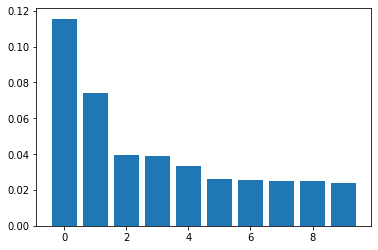

In [191]:
# 5
best_model = best_model_data['model']
vectorizer = best_model_data['vectorizer']
index_vocabulary = {v:k for k,v in vectorizer.vocabulary_.items()}
feature_importance = list(sorted(enumerate(best_model.feature_importances_), key=lambda x: x[1], reverse=True))

for key, value in feature_importance[:10]:
    print(f'Word: {key:<2} {index_vocabulary[key]:<10} has score {value}')

plt.bar([x for x in range(10)], [data[1] for data in feature_importance[:10]])

plt.show()


In [192]:
# 6
SVC_model = SVC(
    C=1.0,
    kernel='rbf',
    decision_function_shape='ovr'
)
logistic_regression_model = LogisticRegression(
    penalty='l2',
    n_jobs=-1,
)
SVC_model.fit(best_model_data['x_train'], best_model_data['y_train'])
logistic_regression_model.fit(best_model_data['x_train'], best_model_data['y_train'])


LogisticRegression(n_jobs=-1)

In [193]:
best_model_predictions = best_model.predict(best_model_data['x_test'])
SVC_predictions = SVC_model.predict(best_model_data['x_test'])
logistic_regression_predictions = logistic_regression_model.predict(best_model_data['x_test'])
SVC_score = metrics.accuracy_score(best_model_data["y_test"], SVC_predictions)
logistic_regression_score = metrics.accuracy_score(best_model_data["y_test"], logistic_regression_predictions)

print(f'Original model score:               {best_model_data["accuracy"]}')
print(f'SVC model score:                    {SVC_score}')
print(f'logistic regression model score:    {logistic_regression_score}')

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.1s finished


Original model score:               0.6014554275318374
SVC model score:                    0.5991510006064281
logistic regression model score:    0.6037598544572468


[[ 521   75   44   39  664]
 [ 161 1005   21   74  445]
 [ 113   89  641   43  400]
 [  89   46   39 1330  412]
 [ 212   41   29  231 1481]]


<AxesSubplot:>

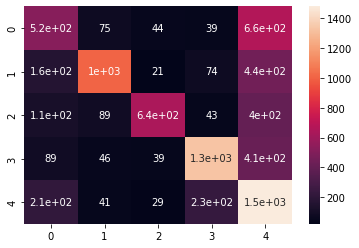

In [195]:
# 7
final_predictions = None
max_score = max(best_model_data['accuracy'], SVC_score, logistic_regression_score)
if max_score == best_model_data['accuracy']:
    final_predictions = best_model_predictions
elif max_score == SVC_score:
    final_predictions = SVC_predictions
else:
    final_predictions = logistic_regression_predictions

confusion_matrix = metrics.confusion_matrix(best_model_data['y_test'], final_predictions)
print(confusion_matrix)
sns.heatmap(confusion_matrix, annot=True)
